## **MLLIBS**

### **Setup Interpreter**

Some test code that shows how to use mllibs

In [1]:
from mllibs.nlpm import nlpm
from mllibs.nlpi import nlpi
from mllibs.meda_scplot import eda_colplot,configure_colplot
from mllibs.meda_splot import eda_plot,configure_edaplt
from mllibs.mseda import simple_eda,configure_eda
from mllibs.moutliers import data_outliers,configure_outliers
import pandas as pd
import json
import os

# link all modules into one collection
collection = nlpm()
collection.load([
                 simple_eda(configure_eda),
                 eda_plot(configure_edaplt),
                 eda_colplot(configure_colplot),
                 data_outliers(configure_outliers),
                ])
collection.train()

# create interpreter from a collection of grouped modules
interpreter = nlpi(collection)

housing = pd.read_csv('data/boston_house_prices.csv')
penguins = pd.read_csv('data/penguins.csv')
interpreter.store_data(housing,'housing')
interpreter.store_data(penguins,'penguins')

loading modules ...
making module summary labels...
eda LogisticRegression() accuracy 1.0
eda_colplot LogisticRegression() accuracy 1.0
eda_plot LogisticRegression() accuracy 1.0
outliers LogisticRegression() accuracy 1.0
ms LogisticRegression() accuracy 1.0
models trained...

data information for housing
{'data': None, 'subset': None, 'splits': {}, 'splits_col': {}, 'features': ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'], 'target': None, 'cat': [], 'num': ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'], 'miss': False, 'corpus': [], 'size': 506, 'dim': 14, 'model_prediction': {}, 'model_correct': {}, 'model_error': {}, 'outliers': {}, 'dimred': {}}

data information for penguins
{'data': None, 'subset': None, 'splits': {}, 'splits_col': {}, 'features': ['id', 'species', 'island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex', 'year'], 't

plot parameter updated!
[note] NER used to clean input text!
create seaborn relplot use penguins
using module: eda_plot
Executing Module Task: srelplot


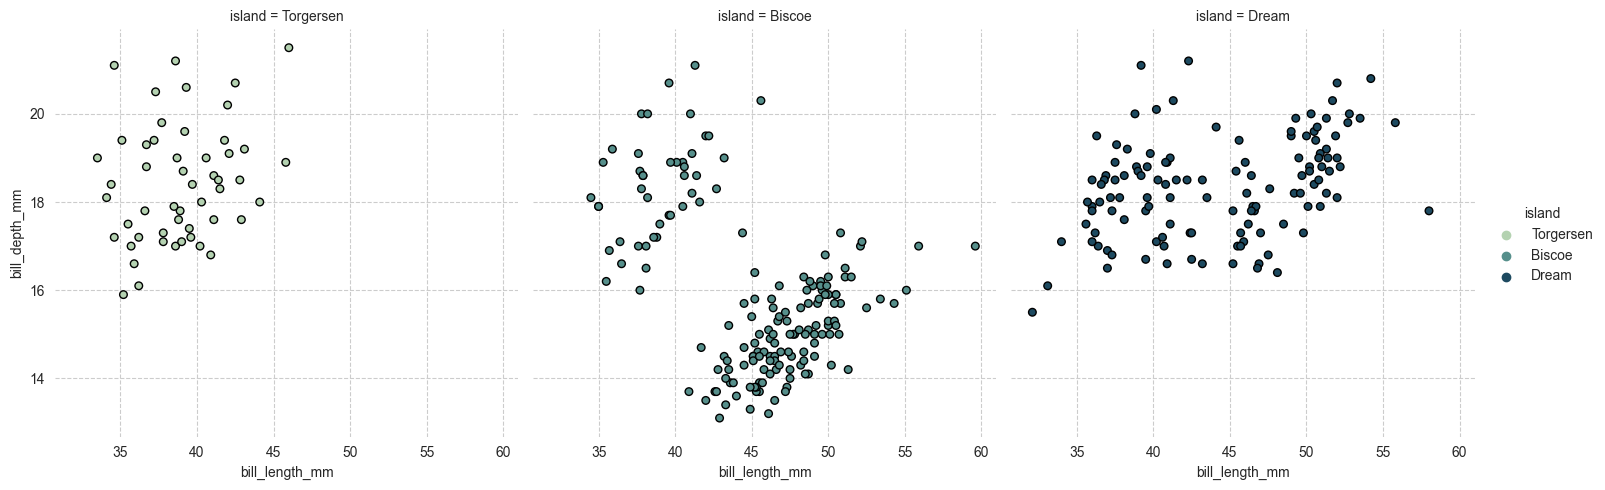

In [3]:
interpreter.setpp({'fill':True,'alpha':1,'mew':1})

# interpreter['create seaborn boxplot using housing y AGE x RAD alpha: 0.3 mew 1 mec 1']
# interpreter['create seaborn scatterplot using penguins x bill_length_mm y bill_depth_mm hue island alpha: 0.3 mew 1 mec 1']
interpreter['create seaborn relplot use penguins x: bill_length_mm y: bill_depth_mm hue island col=island alpha=1.0']

In [4]:
interpreter.mtoken_info

,index_id,type,ner_tags,data,dtype,column,key,index,ttype,ttype_storage
token,,,,,,,,,,
create,0,uni,O,NaN,NaN,NaN,NaN,NaN,str,create
seaborn,1,uni,O,NaN,NaN,NaN,NaN,NaN,str,seaborn
relplot,2,uni,O,NaN,NaN,NaN,NaN,NaN,str,relplot
use,3,uni,O,NaN,NaN,NaN,NaN,NaN,str,use
penguins,4,uni,O,1.0,pd.DataFrame,NaN,NaN,NaN,str,penguins


### **NER Tagger**

Create `NER` tagger to identify words/tokens of interest in input request, it is used to set parameters & remove irrelovant tokens before feeding the input into the classifier

In [7]:
from typing import List
import regex as re
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd    
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix

'''

PARSER FOR THE DATASET NER TAG FORMAT

'''

class Parser:
    
    # RE patterns for tag extraction
    LABEL_PATTERN = r"\[(.*?)\]"
    PUNCTUATION_PATTERN = r"([,\/#!$%\^&\*;:{}=\-`~()'\"’¿])"
    
    # initialise, first word/id tag is O (outside)
    def __init__(self):
        self.tag_to_id = {
            "O": 0
        }
        self.id_to_tag = {
            0: "O"
        }
        
    ''' CREATE TAGS '''
        
    # input : sentence, tagged sentence
        
    def __call__(self, sentence: str, annotated: str) -> List[str]:
        
        ''' Create Dictionary of Identified Tags'''
        
        # 1. set label B or I    
        matches = re.findall(self.LABEL_PATTERN, annotated)
        word_to_tag = {}
        
        for match in matches:            
            if(" : " in match):
                tag, phrase = match.split(" : ")
                words = phrase.split(" ") 
                word_to_tag[words[0]] = f"B-{tag.upper()}"
                for w in words[1:]:
                    word_to_tag[w] = f"I-{tag.upper()}"
                
        ''' Tokenise Sentence & add tags to not tagged words (O)'''
                
        # 2. add token tag to main tag dictionary

        tags = []
        sentence = re.sub(self.PUNCTUATION_PATTERN, r" \1 ", sentence)
        
        for w in sentence.split():
            if w not in word_to_tag:
                tags.append("O")
            else:
                tags.append(word_to_tag[w])
                self.__add_tag(word_to_tag[w])
                
        return tags
    
    ''' TAG CONVERSION '''
    
    # to word2id (tag_to_id)
    # to id2word (id_to_tag)

    def __add_tag(self, tag: str):
        if tag in self.tag_to_id:
            return
        id_ = len(self.tag_to_id)
        self.tag_to_id[tag] = id_
        self.id_to_tag[id_] = tag
        
        ''' Get Tag Number ID '''
        # or just number id for token
        
    def get_id(self, tag: str):
        return self.tag_to_id[tag]
    
    ''' Get Tag Token from Number ID'''
    # given id get its token
    
    def get_label(self, id_: int):
        return self.get_tag_label(id_)
    
# pattern for tokenisation
PUNCTUATION_PATTERN = r"([,\/#!$%\^&\*;:{}=\-`~()'\"’¿])"

# customiser tokeniser
def cust_tokeniser(inputs):
    sentence = re.sub(PUNCTUATION_PATTERN, r" \1 ", inputs)
    return sentence.split()

# parser
parser = Parser()
df = pd.read_csv('out_annot_question_splitter.csv')   # read dataframe

def make_model(parser,df):

    # parse our NER tag data & tokenise our text
    lst_data = []; lst_tags = []
    for ii,row in df.iterrows():
        sentence = re.sub(PUNCTUATION_PATTERN, r" \1 ", row['question'])
        lst_data.extend(sentence.split())
        lst_tags.extend(parser(row["question"], row["annotated"]))
    
    ldf = pd.DataFrame({'data':lst_data,
                        'tag':lst_tags})
    
    ''' 
    
    Vectorisation 
    
    '''
        
    # define encoder
    encoder = CountVectorizer(tokenizer=cust_tokeniser)
    
    # fit the encoder on our corpus
    X = encoder.fit_transform(lst_data)
    y = np.array(lst_tags)
    
    ''' 
    
    Modeling 
    
    '''
    
    # try our different models
    # model_confirm = LogisticRegression()
    model_confirm = RandomForestClassifier()
    
    # train model
    model_confirm.fit(X,y)
    y_pred = model_confirm.predict(X)
    print(f'accuracy: {round(accuracy_score(y_pred,y),3)}')

    print(classification_report(y, y_pred))
    print(confusion_matrix(y,y_pred))
    return model_confirm,encoder

model,encoder = make_model(parser,df)

accuracy: 0.992
              precision    recall  f1-score   support

     B-PARAM       1.00      1.00      1.00        75
        B-PP       1.00      1.00      1.00         9
    B-SOURCE       0.95      1.00      0.97        35
    I-SOURCE       0.00      0.00      0.00         1
           O       1.00      0.99      0.99       244

    accuracy                           0.99       364
   macro avg       0.79      0.80      0.79       364
weighted avg       0.99      0.99      0.99       364

[[ 75   0   0   0   0]
 [  0   9   0   0   0]
 [  0   0  35   0   0]
 [  0   0   0   0   1]
 [  0   0   2   0 242]]


In [8]:

inputs = "create scatterplot using data and x A y B and hue C"
inputs = "create relplot using data x flow, y length col:A and row D, alpha 0.1"
inputs = "create seaborn scatterplot using penguins x bill_length_mm y bill_depth_mm hue island"

# predict NER tags
def ner_predict(inputs):
    # tokens = word_tokenize(inputs)
    tokens = cust_tokeniser(inputs)
    y_pred_test = model.predict(encoder.transform(tokens))

    return pd.DataFrame({"input":tokens,
                         "pred":y_pred_test})


ner_predict(inputs).T

,0,1,2,3,4,5,6,7,8,9,10
input,create,seaborn,scatterplot,using,penguins,x,bill_length_mm,y,bill_depth_mm,hue,island
pred,O,O,O,B-SOURCE,O,B-PARAM,O,B-PARAM,O,B-PARAM,O
